In [41]:
# 导入库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import portfolio_construction_functions as pc

In [42]:
# 导入情感数据
path_Reuters = '../Data/Sentiment_Scores/Merged Sentiment Reuters.csv'
path_MW = '../Data/Sentiment_Scores/Merged Sentiment MW.csv'
path_CNN = '../Data/Sentiment_Scores/Merged Sentiment CNN.csv'
path_TG = '../Data/Sentiment_Scores/Merged Sentiment TG.csv'

df_Reuters_sentiment = pd.read_csv(path_Reuters)
df_MW_sentiment = pd.read_csv(path_MW)
df_CNN_sentiment = pd.read_csv(path_CNN)
df_TG_sentiment = pd.read_csv(path_TG)

# 拼接两个网站的情感分数
df_sentiment = [df_MW_sentiment, df_Reuters_sentiment, df_CNN_sentiment, df_TG_sentiment]
# df_sentiment = [df_MW_sentiment]
# df_sentiment = [df_Reuters_sentiment]
df_sentiment = pd.concat(df_sentiment)
df_sentiment = df_sentiment.groupby(['Date', 'Country']).mean(numeric_only=True).reset_index()

# 修改列名
df_sentiment = df_sentiment.rename(columns={
    'LMD_Polarity': 'LMD',
    'HIV4_Polarity': 'HIV4',
    'Vader_Polarity': 'Vader',
    'FinBert_Polarity': 'FinBert'
})

# 展示数据
df_sentiment.head()

,Date,Country,Unnamed: 0,LMD,HIV4,Vader,FinBert,Unnamed: 0.1
0,2012-01-01,Australia,0.0,NaN,NaN,NaN,NaN,0.0
1,2012-01-01,Canada,4199.0,NaN,NaN,NaN,NaN,1.0
2,2012-01-01,China,8398.0,NaN,NaN,NaN,NaN,2.0
3,2012-01-01,Denmark,12597.0,NaN,NaN,NaN,NaN,3.0
4,2012-01-01,Finland,16796.0,NaN,NaN,NaN,NaN,4.0


In [43]:
# 导入收益率数据
df_return = pd.read_csv('../Data/daily_return_modified.csv')

# 展示数据
df_return.head()

# # 展示为0或者NA的数据的数量
# print('Number of 0 or NA in each column:')
# print(df_return.isin([0, np.nan]).sum())


,Date,New Zealand,United Kingdom,Finland,Norway,United States,Sweden,South Korea,Japan,Canada,...,Australia,Germany,France,China,Switzerland,Spain,Denmark,Italy,Singapore,Portugal
0,2011-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-12-02,-0.010866,-0.207038,0.302897,0.235483,0.489692,0.154354,0.094609,-0.042270,0.178307,...,0.053087,0.393824,-1.345329,0.328191,0.241278,0.536400,0.065521,-0.189497,-0.251753,0.148492
2,2011-12-05,0.077141,-0.460678,-0.474224,-0.158909,-0.084015,-0.179613,0.056292,0.165816,0.227525,...,0.302855,-0.615728,1.099039,0.264403,-0.125720,3.778843,-1.723893,5.259712,-0.012405,3.308727
3,2011-12-06,0.201784,0.810078,0.100602,-0.190226,-0.406179,0.198203,-0.004941,0.066255,-0.330724,...,0.354603,0.150150,-0.863361,-0.157734,0.335027,-0.630513,0.272330,0.715348,0.047384,1.062182
4,2011-12-07,0.187048,0.129148,0.496636,0.290407,0.543003,0.567308,-0.043160,0.002849,0.596567,...,-0.273399,0.762903,0.199724,0.001528,0.198283,-1.476326,-0.028845,-0.948723,-0.251362,1.737582


In [44]:
# 转换日期格式
df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'], format='%Y-%m-%d')
df_return['Date'] = pd.to_datetime(df_return['Date'], format='%Y-%m-%d')

# 生成日期范围
all_dates = pd.date_range(start='2012-01-01', end='2023-06-30').tolist()
df_return = df_return[df_return['Date'].isin(all_dates)]
df_sentiment = df_sentiment[df_sentiment['Date'].isin(all_dates)]

# 去掉无用的列
df_sentiment = df_sentiment.drop(columns=['Unnamed: 0'])
df_sentiment = df_sentiment.drop(columns=['Unnamed: 0.1'])


# 过滤掉周末的情感数据
df_sentiment = df_sentiment[df_sentiment['Date'].dt.dayofweek < 5]


# 填充NA为0
df_sentiment = df_sentiment.fillna(0)

# Calculate the average sentiment for each country
average_polarity = df_sentiment[['LMD', 'HIV4', 'Vader', 'FinBert']].mean(axis=1)

# Create a new DataFrame to store the results
df_sentiment_aver = pd.DataFrame({
    'Date': df_sentiment['Date'],
    'Country': df_sentiment['Country'],
    'Average': average_polarity
})

# Rank the average sentiment for each day
df_sentiment_aver['Average_Rank'] = df_sentiment_aver.groupby('Date')['Average'].rank(ascending=False, method='first')


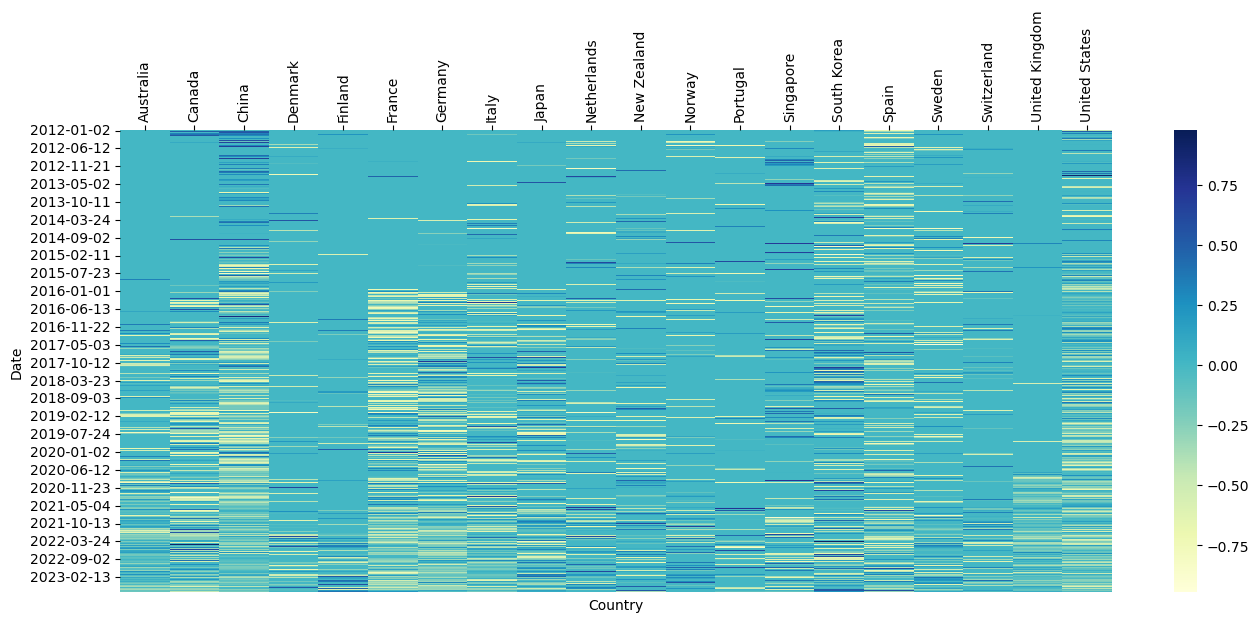

In [45]:
# 展示数据的Heatmap图, 颜色越深代表情感分数越高, 也就是越值得投资
pc.plot_sentiment_heatmap(df_sentiment_aver, '../Data/Images/Heatmap.png')
plt.show()

In [46]:
# 将Average_Polarity和Return赋给merged_data
merged_data = pd.merge(df_sentiment_aver, df_sentiment, on=['Date', 'Country'], how='outer')
df_return_melted = df_return.melt(id_vars='Date', var_name='Country', value_name='Return')
merged_data = pd.merge(merged_data, df_return_melted, on=['Date', 'Country'], how='outer')
column_order = ['Date', 'Country', 'LMD', 'HIV4', 'Vader', 'FinBert', 'Average', 'Return']
merged_data = merged_data[column_order]

merged_data

,Date,Country,LMD,HIV4,Vader,FinBert,Average,Return
0,2012-01-02,Australia,0.000000,0.000000,0.000000,0.000000,0.000000,0.006376
1,2012-01-02,Canada,0.000000,0.000000,0.000000,0.000000,0.000000,0.005310
2,2012-01-02,China,-0.187302,0.101449,0.212200,-0.297623,-0.042819,0.009373
3,2012-01-02,Denmark,0.000000,0.000000,0.000000,0.000000,0.000000,-0.338765
4,2012-01-02,Finland,0.000000,0.000000,0.000000,0.000000,0.000000,-0.558697
...,...,...,...,...,...,...,...,...
59995,2023-06-30,Spain,-0.288889,0.333333,0.999400,0.000000,0.260961,0.199337
59996,2023-06-30,Sweden,-0.916667,0.060150,-0.868500,-0.821184,-0.636550,0.025266
59997,2023-06-30,Switzerland,0.000000,0.000000,0.000000,0.000000,0.000000,0.154802
59998,2023-06-30,United Kingdom,-0.697465,-0.048263,-0.276320,-0.790553,-0.453150,-0.051370


In [47]:
merged_data = merged_data.dropna(subset=['Return'])

## Correlation And Accuracy

In [48]:
correlations_result = pc.check_correlation(merged_data, 'Return')
print(correlations_result)

     Method  Correlation with Return
22  FinBert                 0.011725
25      LMD                 0.007701
27  Average                -0.001121
29    Vader                -0.008271
31     HIV4                -0.018451


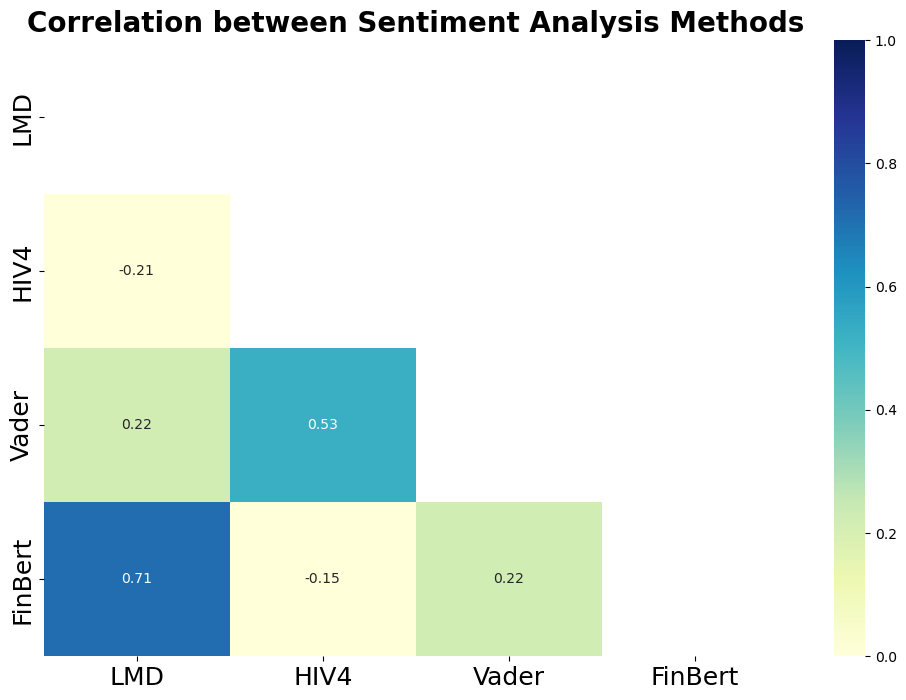

In [49]:
pc.plot_correlation_heatmap(merged_data, columns=['LMD','HIV4','Vader', 'FinBert'], title="Correlation between Sentiment Analysis Methods")
plt.show()

In [50]:
# 使用不同的策略计算收益率
strategies = ['LMD', 'HIV4', 'Vader', 'FinBert', 'Average']
dict_ret = pc.compute_strategy_performance(merged_data, strategies, all_dates)

new_portfolio_25 = pd.DataFrame(dict_ret).transpose()
new_portfolio_25 = new_portfolio_25.rename(columns={0: 'LMD', 1: 'HIV4', 2: 'Vader', 3: 'FinBert', 4: 'Average'})
new_portfolio_25.reset_index(inplace=True)
new_portfolio_25.rename(columns={'index': 'Date'}, inplace=True)

# new_portfolio_25.to_csv('../Data/25_percent_portfolio.csv')

In [51]:
new_portfolio_25

,Date,LMD,HIV4,Vader,FinBert,Average
0,2012-01-01,0.000000,0.000000,0.000000,0.000000,0.000000
1,2012-01-02,-0.278278,0.208891,0.027342,-0.283454,-0.155900
2,2012-01-03,0.265308,-0.176210,0.243632,0.265308,0.243632
3,2012-01-04,-0.187240,0.057219,-0.037385,-0.159385,-0.037385
4,2012-01-05,0.278330,-0.394548,0.260606,0.178183,0.363224
...,...,...,...,...,...,...
4194,2023-06-26,0.144517,0.327044,0.244262,-0.259177,0.244262
4195,2023-06-27,-0.161056,0.128668,0.026598,-0.160139,0.007986
4196,2023-06-28,-0.287834,0.312570,0.069496,-0.263978,0.069496
4197,2023-06-29,0.326308,0.127469,-0.211621,0.303621,0.136917


### IR of Long-Short Portfolio

In [52]:
IR_values = pc.compute_information_ratio(new_portfolio_25, strategies)
print(IR_values)

{'LMD': -0.015504199063149331, 'HIV4': -0.004804884880768951, 'Vader': -0.012288506064251557, 'FinBert': 0.006207362018550978, 'Average': -0.011531274265324909}


In [53]:
# 计算年化收益率
annualized_ret = pc.compute_annualized_return(new_portfolio_25, strategies)
print(annualized_ret)

{'LMD': nan, 'HIV4': nan, 'Vader': nan, 'FinBert': 0.10539629846527276, 'Average': nan}


/Users/wanghs/PycharmProjects/ContextualSentimentInvestmentTool/Part 4 PortfolioConstruction/portfolio_construction_functions.py:206: RuntimeWarning: invalid value encountered in double_scalars
  annualized_ret = (1 + total_return) ** (252 / total_days) - 1


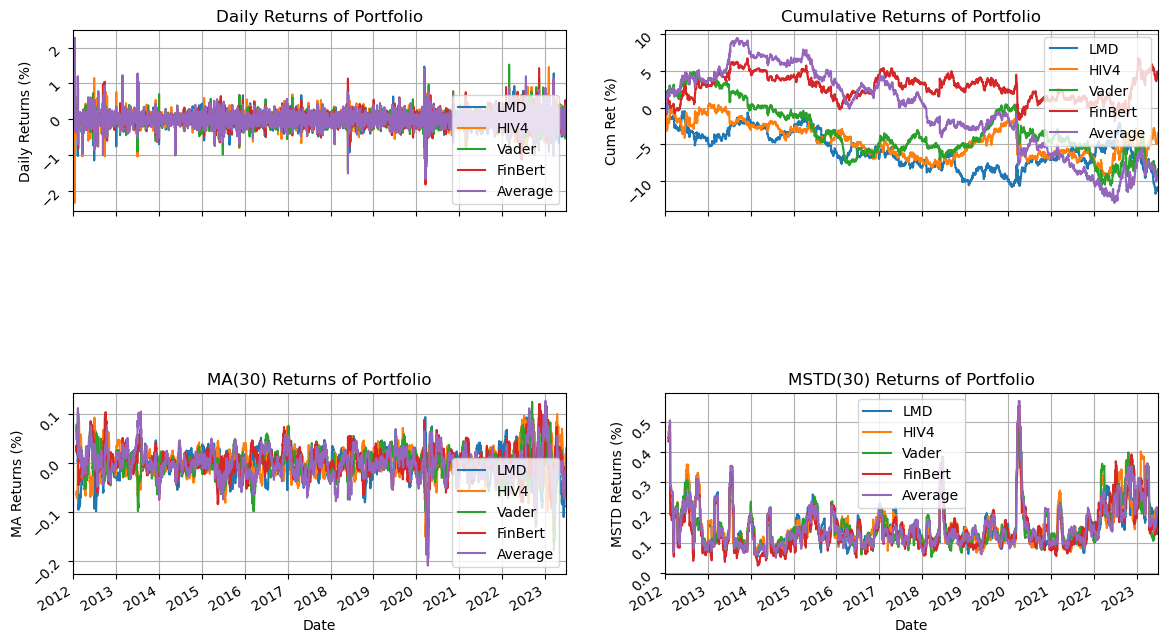

In [54]:
pc.plot_portfolio_summary(new_portfolio_25, start_date='2012-01-01', end_date='2023-06-30')
plt.show()

In [55]:
# 计算累计收益率
df = new_portfolio_25.copy()
# Determine the total number of trading days in the dataset
total_days = 3000

# Dictionary to store the annualized returns and cumulative returns
annualized_returns = {}
cumulative_returns = {}  # Note the naming change to avoid conflict
strategies = ['LMD', 'HIV4', 'Vader', 'FinBert', 'Average']
# 创建一个字典来保存每种策略的夏普比率
sharpe_ratios = {}

for strategy in strategies:
    # print(df[strategy].describe())
    # Compute the cumulative return for the strategy
    cumulative_ret = (1 + df[strategy]/100).prod() - 1
    cumulative_returns[strategy] = cumulative_ret  # Store in dictionary
    
    # Calculate the annualized return
    annualized_ret = (1 + cumulative_ret) ** (252 / total_days) - 1
    annualized_returns[strategy] = annualized_ret  # Store in dictionary
    
    # 计算年化标准差，同样注意将日标准差转化为年化标准差
    annualized_std_dev = df[strategy].std() * np.sqrt(252)

    # 计算夏普比率
    sharpe_ratio = (annualized_ret) / annualized_std_dev

    # 将计算结果存入字典
    sharpe_ratios[strategy] = sharpe_ratio

print("Annualized Returns:", annualized_returns)
print("Cumulative Returns:", cumulative_returns)


Annualized Returns: {'LMD': -0.009692823566103681, 'HIV4': -0.0034550516425431166, 'Vader': -0.008014550256892905, 'FinBert': 0.0031437982123876385, 'Average': -0.007554236245041701}
Cumulative Returns: {'LMD': -0.10948348264910868, 'HIV4': -0.040365491294050315, 'Vader': -0.09135037229005472, 'FinBert': 0.03807440370348081, 'Average': -0.08631808815005049}


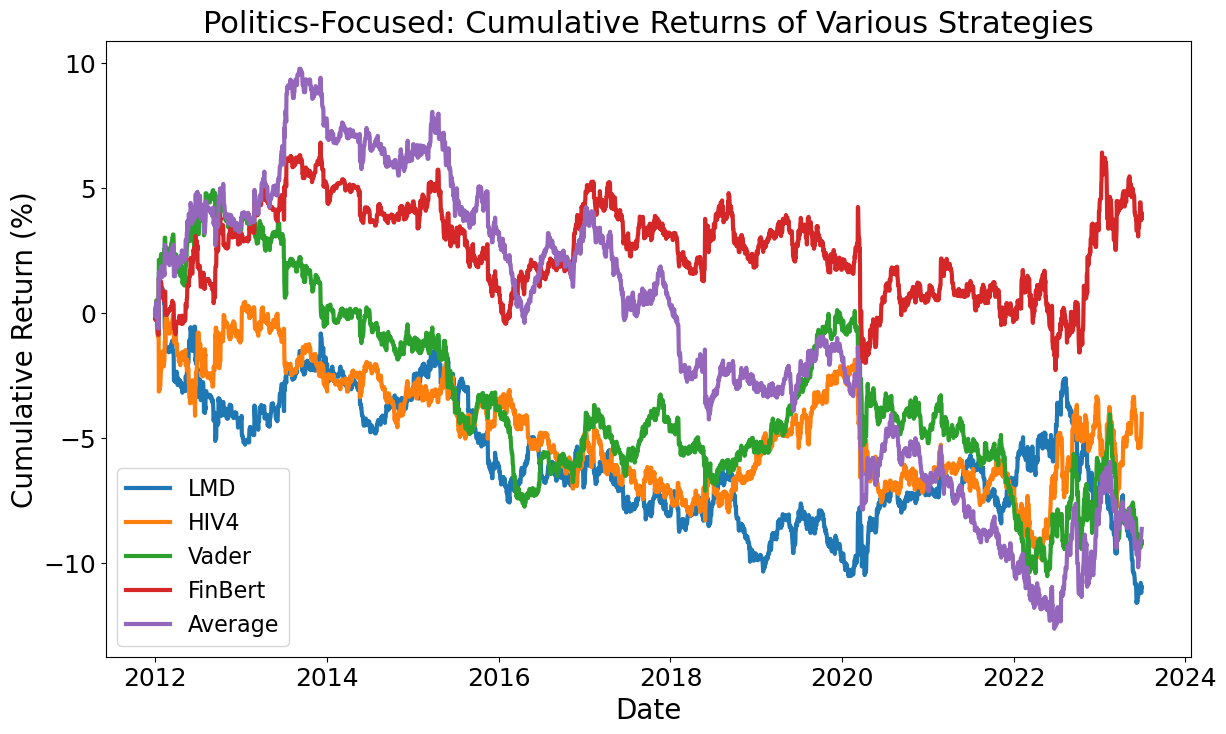

In [61]:
for strategy in strategies:
    df[f'{strategy}_cumulative'] = ((1 + df[strategy]/100).cumprod() - 1) * 100

# 绘图
plt.figure(figsize=(14, 8))
for strategy in strategies:
    plt.plot(df['Date'], df[f'{strategy}_cumulative'], label=f'{strategy}', linewidth=3)

plt.title('Politics-Focused: Cumulative Returns of Various Strategies', fontsize=22)
plt.xlabel('Date', fontsize=20)
plt.xticks(fontsize=18, rotation=0)
plt.ylabel('Cumulative Return (%)', fontsize=20)
plt.yticks(fontsize=18, rotation=0)
plt.legend(fontsize=16)
# plt.tight_layout()
plt.savefig('../Data/Images/fig6-4.png', dpi=600)
plt.show()

In [57]:
# 输出每种策略的最大累积收益率
for strategy in strategies:
    max_cumulative_return = df[f'{strategy}_cumulative'].max()
    print(f"The maximum cumulative return for {strategy} is {max_cumulative_return:.2f}%")


The maximum cumulative return for LMD is 1.42%
The maximum cumulative return for HIV4 is 0.44%
The maximum cumulative return for Vader is 4.91%
The maximum cumulative return for FinBert is 6.80%
The maximum cumulative return for Average is 9.75%


In [58]:
import numpy as np
# 定义无风险利率，例如0.01代表1%
risk_free_rate = 0

# 创建一个字典来保存每种策略的夏普比率
sharpe_ratios = {}

# 计算每种策略的夏普比率
for strategy in strategies:
    # 计算年化收益率，注意将日收益率转化为年化收益率
    annualized_return = ((1 + df[strategy]).mean()) ** 252 - 1

    # 计算年化标准差，同样注意将日标准差转化为年化标准差
    annualized_std_dev = df[strategy].std() * np.sqrt(252)

    # 计算夏普比率
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std_dev

    # 将计算结果存入字典
    sharpe_ratios[strategy] = sharpe_ratio

# 输出结果
for strategy, sharpe_ratio in sharpe_ratios.items():
    print(f"The Sharpe Ratio for {strategy} is {sharpe_ratio:.4f}")
 

The Sharpe Ratio for LMD is -0.1803
The Sharpe Ratio for HIV4 is -0.0688
The Sharpe Ratio for Vader is -0.1510
The Sharpe Ratio for FinBert is 0.1124
The Sharpe Ratio for Average is -0.1439


In [59]:
ir_dict = {}  # 用于存储 IR 的字典

for strategy in strategies:
    mean_return = np.mean(df[strategy])  # 计算平均收益
    std_dev = np.std(df[strategy])  # 计算标准差

    if std_dev != 0:
        information_ratio = mean_return / std_dev  # 计算 IR
    else:
        information_ratio = np.nan  # 如果标准差为0，则IR为未定义

    ir_dict[strategy] = information_ratio  # 存储到字典

print("Information Ratios:", ir_dict)

Information Ratios: {'LMD': -0.015504199063149331, 'HIV4': -0.004804884880768951, 'Vader': -0.012288506064251557, 'FinBert': 0.006207362018550978, 'Average': -0.011531274265324909}


In [60]:
# 定义无风险利率，例如0.01代表1%
risk_free_rate = 0

# 创建一个字典来保存每种策略的夏普比率
sharpe_ratios = {}

# 按照工作日计算，一年有大约252个交易日
annual_factor = np.sqrt(252)

# 计算每种策略的夏普比率
for strategy in strategies:
    # 计算年化收益率，注意将日收益率转化为年化收益率
    annualized_return = ((1 + df[strategy]).mean()) ** 252 - 1

    # 计算年化标准差，同样注意将日标准差转化为年化标准差
    annualized_std_dev = (df[strategy]).std() * annual_factor

    # 计算夏普比率
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std_dev

    # 将计算结果存入字典
    sharpe_ratios[strategy] = sharpe_ratio

# 输出结果
for strategy, sharpe_ratio in sharpe_ratios.items():
    print(f"The Sharpe Ratio for {strategy} is {sharpe_ratio:.4f}")

The Sharpe Ratio for LMD is -0.1803
The Sharpe Ratio for HIV4 is -0.0688
The Sharpe Ratio for Vader is -0.1510
The Sharpe Ratio for FinBert is 0.1124
The Sharpe Ratio for Average is -0.1439
